# Investigating Snowfall and its Relation to Droughts

# Notebook to demonstrate the correlation between wintertime snowfall and summertime droughts in Colorado


@author = Andrew Fleming for ESCI 7/896.02  
@date = 2023-05-03  
@license = MIT -- https://opensource.org/licenses/MIT


In [2]:
#Import Libraies
import os
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import numpy as np

In regions located around the Rocky Mountains snowfall plays a major role in the hydrologic cycle. These regions also have trouble in the summertime with water supply and often they experience droughts.

This study will focus on investigating whether or not there is a correlation between snowfall quantity and drought intensity/frequency.

Many parts of the U.S. rely on snowmelt for water resources. Snowmelt from the Rocky Mountains often makes its way to the Colorado River or another major aqueduct, so understanding how much and when snow melts off can predict when droughts are likely to occur.

# Site Description

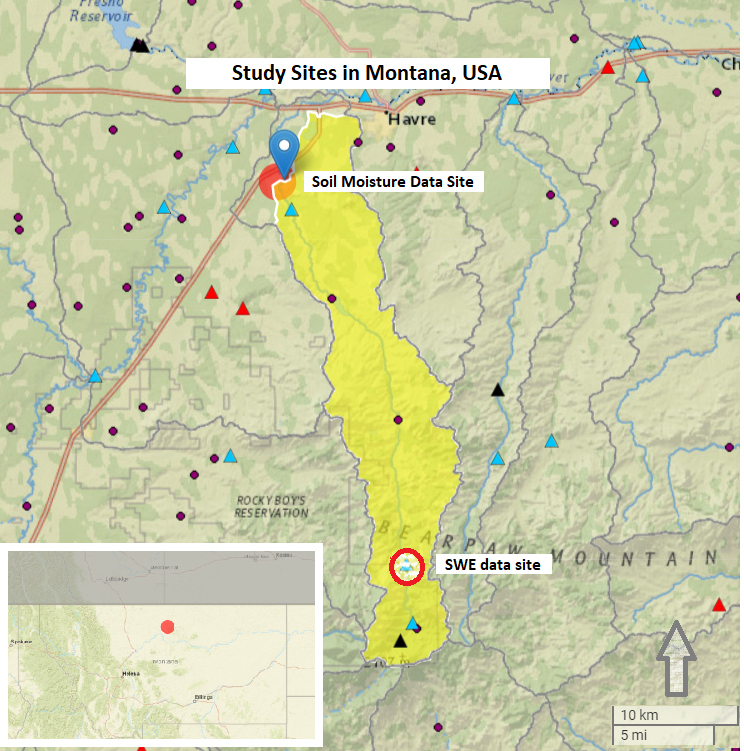

Montana is one of the coldest states in the United States, and because of this an its high elevation Montana recieves large amounts of snowfall each year. Also, because of the mountainous terrain there is a large amount of runoff when this snow melts. These site were selected because the snowpack from the southern site runsoff towards the soil moisture data site located in the north.

# Data Decsription

The data is from two separate Snowtel sites in Montana. One site is for soil moisture (Fort Assiniboine) and one is for Snow water equivalence or SWE (Rocky Boy). The data runs from 1997-2022, and the study period will cover this range of dates.

# Methods and Results

In [3]:
#Specify folder name and variable names
subfolder1_name = 'Snow data'

#%% Load snow data

#Specify folder name and variable names
subfolder1_name = 'Snow data'

#Create function
def readscan(filename):
    #read files
    data_snow = pd.read_csv(filename, header = 1, na_values = [-99.9], 
                   parse_dates=['Date'], index_col='Date')
    #Rename columns
    data_snow = data_snow.rename(columns={'WTEQ.I-1 (in) ': 'SWE_in','PREC.I-1 (in) ': 'Precip_in'})
       
    #Only have integrated data_snow so take difference for daily values
    data_snow['Precip_in']=data_snow['Precip_in'].diff()
    data_snow['SWE_in']=data_snow['SWE_in'].diff()
    
    #resample
    data_snow = data_snow.resample('D').mean(numeric_only=True)
   
    #Convert to cm 
    data_snow['Precip_cm'] = data_snow['Precip_in']*2.54
    data_snow['SWE_cm'] = data_snow['SWE_in']*2.54
   
    #replace negaive values with nan
    data_snow.loc[data_snow['Precip_cm']<0,'Precip_cm'] = np.nan
    data_snow.loc[data_snow['SWE_cm']<0,'SWE_cm'] = np.nan
    
    #Deleat unwanted columns
    data_snow = data_snow[['SWE_cm','Precip_cm']]
    return data_snow

filenames = os.listdir(subfolder1_name)
if 'data_snow' in globals():
    del data_snow
    
for filename in filenames:
    data_snow_small=readscan(subfolder1_name+ '\\' + filename)
    try:
        data_snow= pd.concat([data_snow,data_snow_small])
    except:
        data_snow= data_snow_small


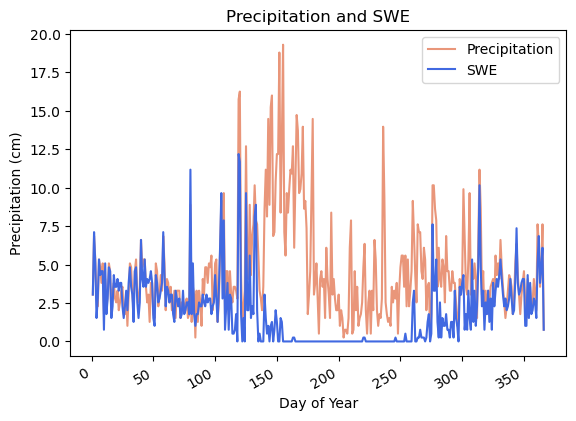

In [4]:
#%%Create Time Series Plot for SWE focusing on Seasonal differences

# Create plot 
fig1, ax = plt.subplots()

# Plot another data series
ax.plot(data_snow['Precip_cm'].groupby(data_snow.index.dayofyear).sum(),  # x = 1st series, y = 2nd series)
        'darksalmon',                            # Line Format
        label = 'Precipitation')         # series label for legend

# Plot one data series 
ax.plot(data_snow['SWE_cm'].groupby(data_snow.index.dayofyear).sum(),  # x = 1st series, y = 2nd series)
        'royalblue',                           # Line Format
        label = 'SWE')       # series label for legend


# Add plot components 
ax.set_xlabel('Day of Year')         # x-axis label 
ax.set_ylabel('Precipitation (cm)')          # y-axis label
ax.set_title('Precipitation and SWE') # figure title
ax.legend()                                   # legend

# Optional command to make x-tick labels diagonal to avoid overlap
fig1.autofmt_xdate() 

The data is downloaded in yearly files, so to load the data a function was created to read ech file in the subfolder and add them onto one another to create one dataframe.

In [5]:
#%% Load soil moisture data

#Specify folder name and variable names
subfolder2_name = 'Soil data'

#Create function
def readscan(filename):
    #read files
    data_sm = pd.read_csv(filename, header = 1, na_values = [-99.9], 
                   parse_dates=['Date'], index_col='Date')
    #Rename columns
    data_sm = data_sm.rename(columns={'SMS.I-1:-2 (pct)  (loam)': 'SM5',
                                'SMS.I-1:-4 (pct)  (loam)': 'SM10','SMS.I-1:-8 (pct)  (loam)': 'SM20',
                                'SMS.I-1:-20 (pct)  (loam)': 'SM50','SMS.I-1:-40 (pct)  (loam)': 'SM100'})
    
    #Replace negatives with nan
    data_sm.loc[data_sm['SM50']<0,'SM50'] = np.nan
    data_sm.loc[data_sm['SM100']<0,'SM100'] = np.nan
    
    #resample
    data_sm = data_sm.resample('D').mean(numeric_only=True)

    data_sm = data_sm[['SM5','SM10','SM20','SM50','SM100']]
    return data_sm

filenames = os.listdir(subfolder2_name)

for filename in filenames:
    data_sm_small=readscan(subfolder2_name+ '\\' + filename)
    try:
        data_sm= pd.concat([data_sm,data_sm_small])
    except:
        data_sm= data_sm_small

#Fill in Missing data
data_sm['SM5'] = data_sm['SM5'].fillna(data_sm['SM10'])
data_sm['SM10'] = data_sm['SM10'].fillna((data_sm['SM5'] +data_sm['SM20'])/2)
data_sm['SM20'] = data_sm['SM20'].fillna((data_sm['SM10'] +data_sm['SM50'])/2)
data_sm['SM50'] = data_sm['SM50'].fillna((data_sm['SM20'] +data_sm['SM100'])/2)
data_sm['SM100'] = data_sm['SM100'].fillna(data_sm['SM50'])

#Integrating  data       
data_sm['tot_soilmoisture'] = np.trapz(data_sm[['SM5', 'SM10', 'SM20', 'SM50', 'SM100']]/100, x = [5,10,20,50,100])

#Isolate SM to summer months
data_sm.loc[~((data_sm.index.month >= 6) | (data_sm.index.month <= 9))] = pd.NA

data_sm = data_sm['1997-01-01':'2022-12-31']

The same process is used to load the soil moisture data as is used for the snow data.

In [6]:
#%% Creating annual data frame for SWE

# Make non-winter months NaN        
data_snow.loc[~((data_snow.index.month >= 12) | (data_snow.index.month <= 3))] = pd.NA

#Remove decemeber 1996
data_snow = data_snow['1997-01-01':'2022-12-31']

#Calculate values
dfannual_swe = data_snow[['SWE_cm']].groupby(data_snow.index.year).sum()
dfannual_swe['Precip_cm'] = data_snow[['Precip_cm']].groupby(data_snow.index.year).sum()

In [7]:
#%% Annual data frame for SM

#Calculate values
dfannual_sm = data_sm[['tot_soilmoisture']].groupby(data_sm.index.year).mean()

#Rename column
dfannual_sm = dfannual_sm.rename(columns={'tot_soilmoisture': 'avg_soilmoisture'})
                                       

The data frames are slightly different sizes so they cannot be plotted against each other. This is why an annual data frame is created for each data set. For SWE the daily amounts are summed, so that the annual data frame represents the total amount of snowfall each year. For the soil moisture data set the total soil moisture values are averaged so that the data set represents the summertime average soil moisture.

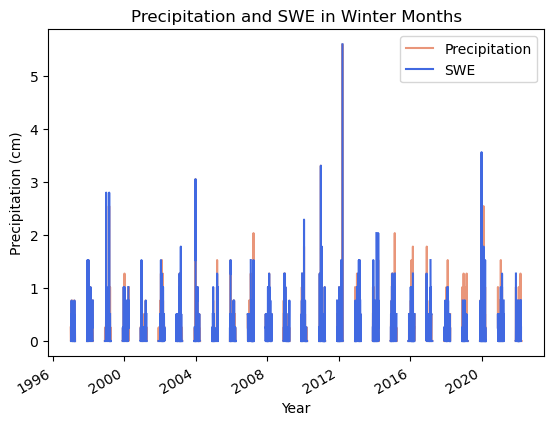

In [8]:
#%%Create Time Series Plot for SWE

# Create plot 
fig1, ax = plt.subplots()

# Plot another data series
ax.plot(data_snow['Precip_cm'],  # x = 1st series, y = 2nd series)
        'darksalmon',                            # Line Format
        label = 'Precipitation')         # series label for legend

# Plot one data series 
ax.plot(data_snow['SWE_cm'],  # x = 1st series, y = 2nd series)
        'royalblue',                           # Line Format
        label = 'SWE')       # series label for legend


# Add plot components 
ax.set_xlabel('Year')         # x-axis label 
ax.set_ylabel('Precipitation (cm)')          # y-axis label
ax.set_title('Precipitation and SWE in Winter Months') # figure title
ax.legend()                                   # legend

# Optional command to make x-tick labels diagonal to avoid overlap
fig1.autofmt_xdate()  
     

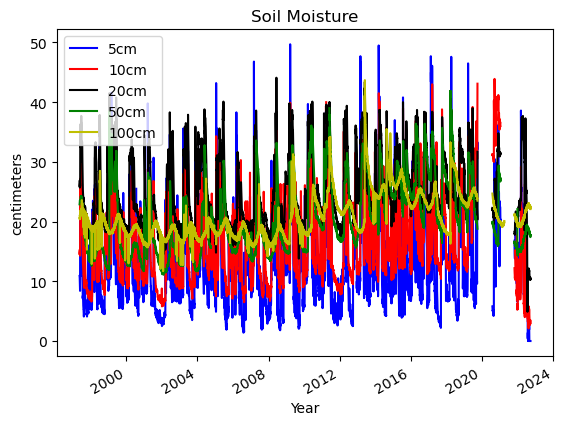

In [9]:
#%%Create Time Series Plot for SM

# Create plot 
fig2, ax2 = plt.subplots()

# Plot another data series
ax2.plot(data_sm['SM5'],  # x = 1st series, y = 2nd series)
        'b',                            # Line Format
        label = '5cm')         # series label for legend

ax2.plot(data_sm['SM10'],  # x = 1st series, y = 2nd series)
        'r',                            # Line Format
        label = '10cm')         # series label for legend

ax2.plot(data_sm['SM20'],  # x = 1st series, y = 2nd series)
        'k',                            # Line Format
        label = '20cm')         # series label for legend

ax2.plot(data_sm['SM50'],  # x = 1st series, y = 2nd series)
        'g',                            # Line Format
        label = '50cm')         # series label for legend

ax2.plot(data_sm['SM100'],  # x = 1st series, y = 2nd series)
        'y',                            # Line Format
        label = '100cm')         # series label for legend


# Add plot components 
ax2.set_xlabel('Year')         # x-axis label 
ax2.set_ylabel('centimeters')          # y-axis label
ax2.set_title('Soil Moisture') # figure title
ax2.legend()                                   # legend

# Optional command to make x-tick labels diagonal to avoid overlap
fig2.autofmt_xdate() 


Daily data time series plots are created to help visualize the individual data sets.

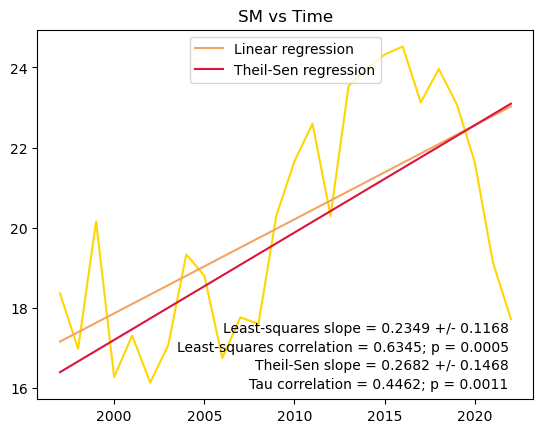

In [10]:
def regressplot1(data1_series,data2_series, figtitle):

    #Calculate parametric linear regression values
    lsq_coeff = stats.linregress(data1_series,data2_series)
    
    #Calculate non-parametric regression values
    sen_coeff = stats.theilslopes(data2_series,data1_series, 0.95)
    
    #Calculate non-parametric correlation
    tau = stats.kendalltau(data1_series,data2_series)

    #Create plot and show time eries of input data series
    fig, ax = plt.subplots()
    ax.plot(data1_series,data2_series, 'gold')
    #Parametric best fit line
    ax.plot(data1_series, lsq_coeff.intercept + lsq_coeff.slope *
          data1_series, 'sandybrown', label='Linear regression')
    #Annotation Placement
    xx = ax.get_xlim()
    yy = ax.get_ylim()

    #Display least squares sparametric slope and correlation on graph
    ax.annotate(f'Least-squares slope = {lsq_coeff.slope:.4f} +/- {2*lsq_coeff.stderr:.4f}',
                xy=(xx[1]-0.05*(xx[1]-xx[0]), yy[0] + 0.18*(yy[1]-yy[0])),
                horizontalalignment='right')
    ax.annotate(f'Least-squares correlation = {lsq_coeff.rvalue:.4f}; p = {lsq_coeff.pvalue:.4f}',
                xy=(xx[1]-0.05*(xx[1]-xx[0]), yy[0] + 0.13*(yy[1]-yy[0])),
                horizontalalignment='right')

    #Non-parametric best fit line
    ax.plot(data1_series, sen_coeff.intercept + sen_coeff.slope *
               data1_series, 'crimson', label='Theil-Sen regression')

    #Display non-parametric slope and correlation on graph
    ax.annotate(f'Theil-Sen slope = {sen_coeff.slope:.4f} +/- {0.5*(sen_coeff.high_slope - sen_coeff.low_slope):.4f}',
                    xy=(xx[1]-0.05*(xx[1]-xx[0]), yy[0] + 0.08*(yy[1]-yy[0])),
                    horizontalalignment='right')
    ax.annotate(f'Tau correlation = {tau.correlation:.4f}; p = {tau.pvalue:.4f}',
                    xy=(xx[1]-0.05*(xx[1]-xx[0]), yy[0] + 0.03*(yy[1]-yy[0])),
                    horizontalalignment='right')

    ax.set_title(figtitle)
    #ax.set_ylabel(y_label)
    ax.legend(loc='upper center')
    plt.show()
    
regressplot1(dfannual_sm.index, dfannual_sm['avg_soilmoisture'], 'SM vs Time')

This graph shows that soil moisture is increasing over time at this site. This is unusual and will be discussed futher in the conclusion section.

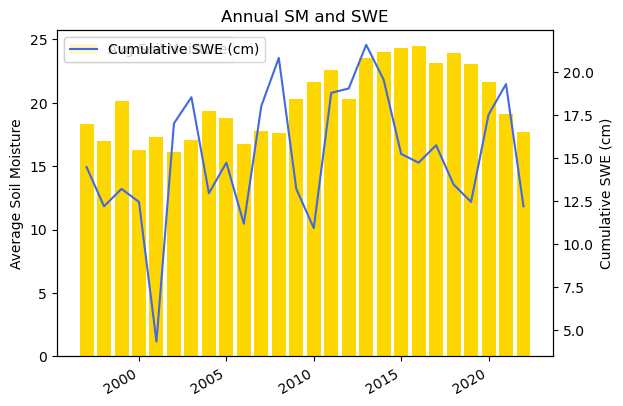

In [11]:
#Figure  
fig4, ax1=plt.subplots()

# Plot a Soil Moisture
plt.bar(dfannual_sm.index, dfannual_sm['avg_soilmoisture'], color = 'gold',
             label = 'Avg Soil Moisture') 

ax1.set_ylabel('Average Soil Moisture')

ax2 = ax1.twinx()

# Plot SWE
ax2.plot(dfannual_swe.index, dfannual_swe['SWE_cm'], color = 'royalblue',
            label = 'Cumulative SWE (cm)')

ax2.set_ylabel('Cumulative SWE (cm)')

#Add Legends
ax1.legend()
ax2.legend()

ax1.set_title('Annual SM and SWE') # figure title

fig4.autofmt_xdate() 

These graphs further compare the data sets visually to try and draw a conclusion.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


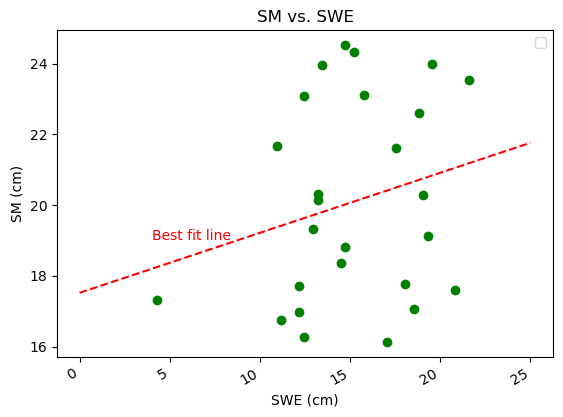

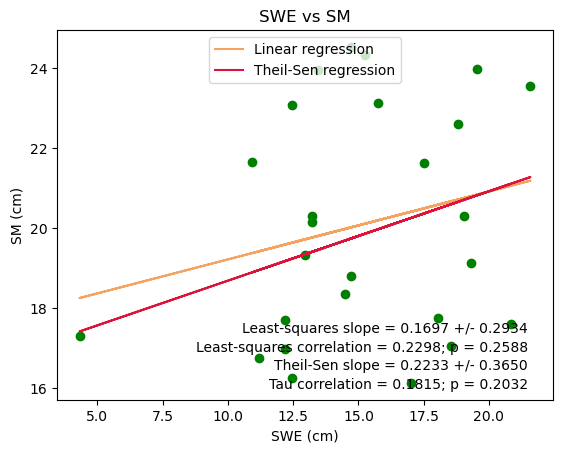

In [12]:
#%%Plot SM vs SWE Annually

# Create plot 
fig3, ax3 = plt.subplots()

# Plot another data series
ax3.plot(dfannual_swe['SWE_cm'], dfannual_sm['avg_soilmoisture'],  # x = 1st series, y = 2nd series)
        'go')                           
             
#Best fit equation
slope,intercept = np.polyfit(dfannual_swe['SWE_cm'], 
                             dfannual_sm['avg_soilmoisture'],1)
#Variables for best fit line
m = slope
b = intercept
x1 =  0
x2 =  25
y1 = m*x1 +b
y2 = m*x2 +b

#Plot best fit line
ax3.plot([x1,x2],[y1,y2],'r--') 
ax3.annotate('Best fit line',xy = (4,19),color = 'r')
# Add plot components 
ax3.set_xlabel('SWE (cm)')         # x-axis label 
ax3.set_ylabel('SM (cm)')          # y-axis label
ax3.set_title('SM vs. SWE') # figure title
ax3.legend()                                   # legend

# Optional command to make x-tick labels diagonal to avoid overlap
fig3.autofmt_xdate() 

#Create function
def regressplot2(data1_series,data2_series, figtitle):

    #Calculate parametric linear regression values
    lsq_coeff = stats.linregress(data1_series,data2_series)
    
    #Calculate non-parametric regression values
    sen_coeff = stats.theilslopes(data2_series,data1_series, 0.95)
    
    #Calculate non-parametric correlation
    tau = stats.kendalltau(data1_series,data2_series)

    #Create plot and show time eries of input data series
    fig, ax = plt.subplots()
    ax.plot(data1_series,data2_series, 'go')
    #Parametric best fit line
    ax.plot(data1_series, lsq_coeff.intercept + lsq_coeff.slope *
          data1_series, 'sandybrown', label='Linear regression')
    #Annotation Placement
    xx = ax.get_xlim()
    yy = ax.get_ylim()

    #Display least squares sparametric slope and correlation on graph
    ax.annotate(f'Least-squares slope = {lsq_coeff.slope:.4f} +/- {2*lsq_coeff.stderr:.4f}',
                xy=(xx[1]-0.05*(xx[1]-xx[0]), yy[0] + 0.18*(yy[1]-yy[0])),
                horizontalalignment='right')
    ax.annotate(f'Least-squares correlation = {lsq_coeff.rvalue:.4f}; p = {lsq_coeff.pvalue:.4f}',
                xy=(xx[1]-0.05*(xx[1]-xx[0]), yy[0] + 0.13*(yy[1]-yy[0])),
                horizontalalignment='right')

    #Non-parametric best fit line
    ax.plot(data1_series, sen_coeff.intercept + sen_coeff.slope *
               data1_series, 'crimson', label='Theil-Sen regression')

    #Display non-parametric slope and correlation on graph
    ax.annotate(f'Theil-Sen slope = {sen_coeff.slope:.4f} +/- {0.5*(sen_coeff.high_slope - sen_coeff.low_slope):.4f}',
                    xy=(xx[1]-0.05*(xx[1]-xx[0]), yy[0] + 0.08*(yy[1]-yy[0])),
                    horizontalalignment='right')
    ax.annotate(f'Tau correlation = {tau.correlation:.4f}; p = {tau.pvalue:.4f}',
                    xy=(xx[1]-0.05*(xx[1]-xx[0]), yy[0] + 0.03*(yy[1]-yy[0])),
                    horizontalalignment='right')
    # Add plot components 
    ax.set_xlabel('SWE (cm)')         # x-axis label 
    ax.set_ylabel('SM (cm)')          # y-axis label
    ax.set_title('Linear and Non-linear Regression') # figure title

    ax.set_title(figtitle)
    #ax.set_ylabel(y_label)
    ax.legend(loc='upper center')
    plt.show()

regressplot2(dfannual_swe['SWE_cm'],dfannual_sm['avg_soilmoisture'], 'SWE vs SM')

These calculations, while they do show a positive trend, indicate that thee is not a significant reationship between snowfall quanity and soil moisture. The fact that there is a positice linear ebst fit could indicate that snowfall is a factor hne it comes to summertime soil moistue, but the p-values confirm that teh relationship sis no significant, so there is anothe rvariable that is more infulencial over soil moisture.

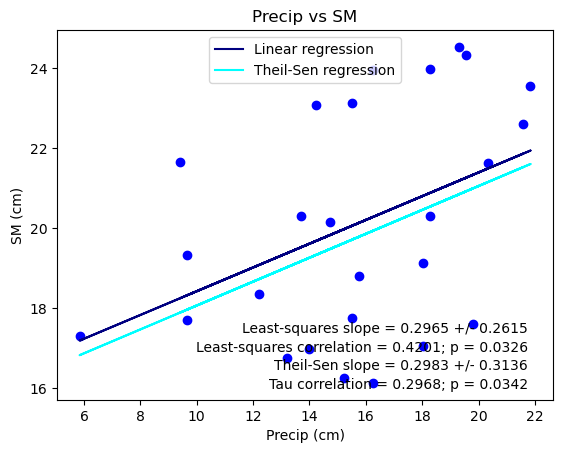

In [13]:
#Create function
def regressplot3(data1_series,data2_series, figtitle):

    #Calculate parametric linear regression values
    lsq_coeff = stats.linregress(data1_series,data2_series)
    
    #Calculate non-parametric regression values
    sen_coeff = stats.theilslopes(data2_series,data1_series, 0.95)
    
    #Calculate non-parametric correlation
    tau = stats.kendalltau(data1_series,data2_series)

    #Create plot and show time eries of input data series
    fig, ax = plt.subplots()
    ax.plot(data1_series,data2_series, 'bo')
    #Parametric best fit line
    ax.plot(data1_series, lsq_coeff.intercept + lsq_coeff.slope *
          data1_series, 'navy', label='Linear regression')
    #Annotation Placement
    xx = ax.get_xlim()
    yy = ax.get_ylim()

    #Display least squares sparametric slope and correlation on graph
    ax.annotate(f'Least-squares slope = {lsq_coeff.slope:.4f} +/- {2*lsq_coeff.stderr:.4f}',
                xy=(xx[1]-0.05*(xx[1]-xx[0]), yy[0] + 0.18*(yy[1]-yy[0])),
                horizontalalignment='right')
    ax.annotate(f'Least-squares correlation = {lsq_coeff.rvalue:.4f}; p = {lsq_coeff.pvalue:.4f}',
                xy=(xx[1]-0.05*(xx[1]-xx[0]), yy[0] + 0.13*(yy[1]-yy[0])),
                horizontalalignment='right')

    #Non-parametric best fit line
    ax.plot(data1_series, sen_coeff.intercept + sen_coeff.slope *
               data1_series, 'aqua', label='Theil-Sen regression')

    #Display non-parametric slope and correlation on graph
    ax.annotate(f'Theil-Sen slope = {sen_coeff.slope:.4f} +/- {0.5*(sen_coeff.high_slope - sen_coeff.low_slope):.4f}',
                    xy=(xx[1]-0.05*(xx[1]-xx[0]), yy[0] + 0.08*(yy[1]-yy[0])),
                    horizontalalignment='right')
    ax.annotate(f'Tau correlation = {tau.correlation:.4f}; p = {tau.pvalue:.4f}',
                    xy=(xx[1]-0.05*(xx[1]-xx[0]), yy[0] + 0.03*(yy[1]-yy[0])),
                    horizontalalignment='right')
    # Add plot components 
    ax.set_xlabel('Precip (cm)')         # x-axis label 
    ax.set_ylabel('SM (cm)')          # y-axis label
    ax.set_title('Linear and Non-linear Regression') # figure title

    ax.set_title(figtitle)
    #ax.set_ylabel(y_label)
    ax.legend(loc='upper center')
    plt.show()
    
regressplot3(dfannual_swe['Precip_cm'],dfannual_sm['avg_soilmoisture'], 'Precip vs SM')

This plot is created to determien what variable could be driving soil oisture if not snowfall, and this plot shows that overall precipitation is the driving factor.

# Discussion and Conclusion

The goal of this study was to determine if annual snowfall influenced summertime soil moisture and therefore droughts. Montana was chosen because it is a very cold region, and it is more likely for colder regions to be dominated by snowfall instead of overall precipitation. Additionally, the western United States has many problems pertaining to droughts and water resources. So, if this study was successful, it could show whether people could use snowfall as a predictor for droughts later in the year.

Unfortunately, the results of this study were not significant. The calculations performed yielded p-values of around 0.2, and a p-value must be less than 0.05 to be considered significant. This means that in this location snowfall does not significantly impact summertime soil moisture. However, the p-value for overall precipitation and soil moisture is 0.03. This means that precipitation is a driving factor. It should also be noted that soil moisture in this location is increasing over time, which is unusual for the western United States. Many places in this region, especially the further south, are regularly experiencing droughts and this is because soil moisture is decreasing over time. Since this is the case, it could mean that this particular site has other variables influencing it that were not accounted for in this study. For example, there could be large amounts of human development near this site that is leading to more runoff towards the site. Although, more information would be needed in order to be certain about this.

While the results of this study were not significant, it is possible that another site could yield better results. Regions with colder weather or more precipitation could show more of a correlation. For example, in the northern parts of New England snowmelt is the driving factor behind flooding events while in southern New England precipitation is the driving factor. This is just one example of how there is often a fine line between regions where snow is dominant and regions where precipitation is dominant.
